This file loads an existing model and starts another training round

In [1]:
import os
print(os.getcwd())
#os.chdir("Project")
#print(os.getcwd())

#put the model names here

existing_model = "model_v1"
save_model_as = "model_v1_improve_01"



/Users/stefanbeller/Documents/SoftwareProjects/online/FH-KI-CV


In [2]:
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [3]:
# Read in label file and return a dictionary {'filename' : label}.
#
def import_labels(label_file):
    labels = dict()

    import csv
    with open(label_file) as fd:
        csvreader = csv.DictReader(fd)

        for row in csvreader:
            labels[row['filename']] = int(row['label'])
    return labels

In [16]:
import tensorflow.keras as keras
from tensorflow.keras.preprocessing import image

import numpy as np
import tensorflow as tf
#tf.debugging.experimental.enable_dump_debug_info(log_dir, tensor_debug_mode="FULL_HEALTH", circular_buffer_size=-1)

class DataGenerator(keras.utils.Sequence):

    def __init__(self, img_root_dir, labels_dict, batch_size, target_dim, preprocess_func=None, use_augmentation=False):
        self._labels_dict = labels_dict
        self._img_root_dir = img_root_dir
        self._batch_size = batch_size
        self._target_dim = target_dim
        self._preprocess_func = preprocess_func
        self._n_classes = len(set(self._labels_dict.values()))
        self._fnames_all = list(self._labels_dict.keys())
        self._use_augmentation = use_augmentation

        if self._use_augmentation:
            self._augmentor = image.ImageDataGenerator(
                rotation_range=40,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                fill_mode='nearest'
            )
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self._fnames_all)) / self._batch_size)

    def on_epoch_end(self):
        self._indices = np.arange(len(self._fnames_all))
        np.random.shuffle(self._indices)

    def __getitem__(self, index):
        indices = self._indices[index * self._batch_size:(index+1)*self._batch_size]

        fnames = [self._fnames_all[k] for k in indices]
        X,Y = self.__load_files__(fnames)

        return X,Y

    def __load_files__(self, batch_filenames):
        X = np.empty((self._batch_size, *self._target_dim, 3))
        Y = np.empty((self._batch_size), dtype=int)

        for idx, fname in enumerate(batch_filenames):
            img_path = os.path.join(self._img_root_dir, fname)
            img = image.load_img(img_path, target_size=self._target_dim)
            x = image.img_to_array(img)
            if self._preprocess_func is not None:
                x = self._preprocess_func(x)

            X[idx,:] = x 
            Y[idx] = self._labels_dict[fname]-1

        if self._use_augmentation:
            it = self._augmentor.flow(X, batch_size=self._batch_size, shuffle=False)
            X = it.next()

        if self._preprocess_func is not None:
            X = self._preprocess_func(X)

        return X, tf.keras.utils.to_categorical(Y, num_classes=self._n_classes)

ModuleNotFoundError: No module named 'tf'

In [5]:
from tensorflow.keras.utils import to_categorical
y_train = import_labels("train_labels.csv")
y_test = import_labels("test_labels.csv")
batch_size=5
image_size = (224, 224)

In [6]:
def preprocess_func(x):
    return x / 255.0

In [7]:
datagen_train = DataGenerator('train', y_train, batch_size, image_size, preprocess_func=preprocess_func, use_augmentation=True)
datagen_test = DataGenerator('test', y_test, batch_size, image_size, preprocess_func=preprocess_func)

In [8]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)

In [11]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = tf.keras.models.load_model(existing_model)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-05-24 21:07:48.409575: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-24 21:07:48.409937: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [12]:
import tensorflow as tf
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="training.ckpt",
                                                 save_weights_only=True,
                                                 verbose=1)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
#model.load_weights("training.ckpt")

In [13]:
# Train model on dataset
history = model.fit(datagen_train, validation_data=datagen_test, epochs=1,callbacks=[cp_callback
                                                                          # ,tensorboard_callback
                                                                          ])

2022-05-24 21:08:12.677422: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-24 21:08:13.002973: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1097/1097 [==============================] - ETA: 0s - loss: 2.5178 - accuracy: 0.3672

2022-05-24 21:13:05.040783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: saving model to training.ckpt
1097/1097 [==============================] - 308s 280ms/step - loss: 2.5178 - accuracy: 0.3672 - val_loss: 5.6813 - val_accuracy: 0.1837


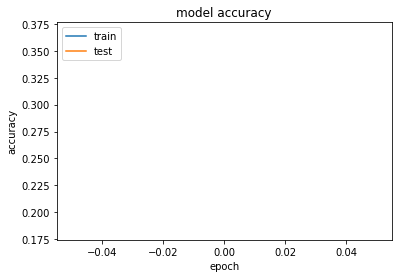

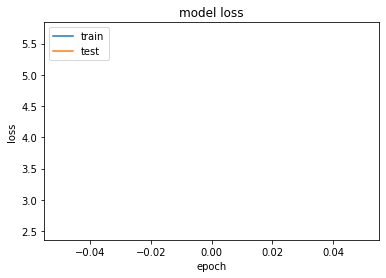

In [14]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
model.save(save_model_as)

2022-05-24 21:13:51.365412: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model_24_05_2022/assets


INFO:tensorflow:Assets written to: model_24_05_2022/assets


##### 